# Akhtar Ali (2021758)

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, year, month, split, explode
import pandas as pd
import matplotlib.pyplot as plt


In [37]:
# Step 1: Initialize SparkSession
spark = SparkSession.builder \
    .appName("Netflix EDA") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Step 2: Load the Netflix Dataset
file_path = "file:///home/jovyan/work/titles.csv"  # Adjust to your environment
df = spark.read.csv(file_path, header=True, inferSchema=True)

## Schema and First 5 Rows

In [38]:
# Step 3: Basic Data Exploration
print("Schema:")
df.printSchema()

print("Total Records:", df.count())

print("First 5 Rows:")
df.show(5)

Schema:
root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- seasons: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- imdb_score: string (nullable = true)
 |-- imdb_votes: string (nullable = true)
 |-- tmdb_popularity: string (nullable = true)
 |-- tmdb_score: string (nullable = true)

Total Records: 5929
First 5 Rows:
+--------+--------------------+-----+--------------------+------------+-----------------+-------+--------------------+--------------------+-------+---------+----------+----------+---------------+----------+
|      id|               title| type|         description|release_year|age_certification|runtime|              genres|prod

## Handling Missing Values

In [39]:
# Step 4: Handle Missing Values
print("Null Values:")
df.select([count(col(c)).alias(c) for c in df.columns]).show()

# Drop rows with missing critical values
df_cleaned = df.dropna(subset=["title", "release_year"])


Null Values:
+----+-----+----+-----------+------------+-----------------+-------+------+--------------------+-------+-------+----------+----------+---------------+----------+
|  id|title|type|description|release_year|age_certification|runtime|genres|production_countries|seasons|imdb_id|imdb_score|imdb_votes|tmdb_popularity|tmdb_score|
+----+-----+----+-----------+------------+-----------------+-------+------+--------------------+-------+-------+----------+----------+---------------+----------+
|5929| 5926|5911|       5889|        5859|             3335|   5808|  5832|                5833|   2245|   5388|      5354|      5329|           5706|      5511|
+----+-----+----+-----------+------------+-----------------+-------+------+--------------------+-------+-------+----------+----------+---------------+----------+



# Visualization

## Distribution of Show types

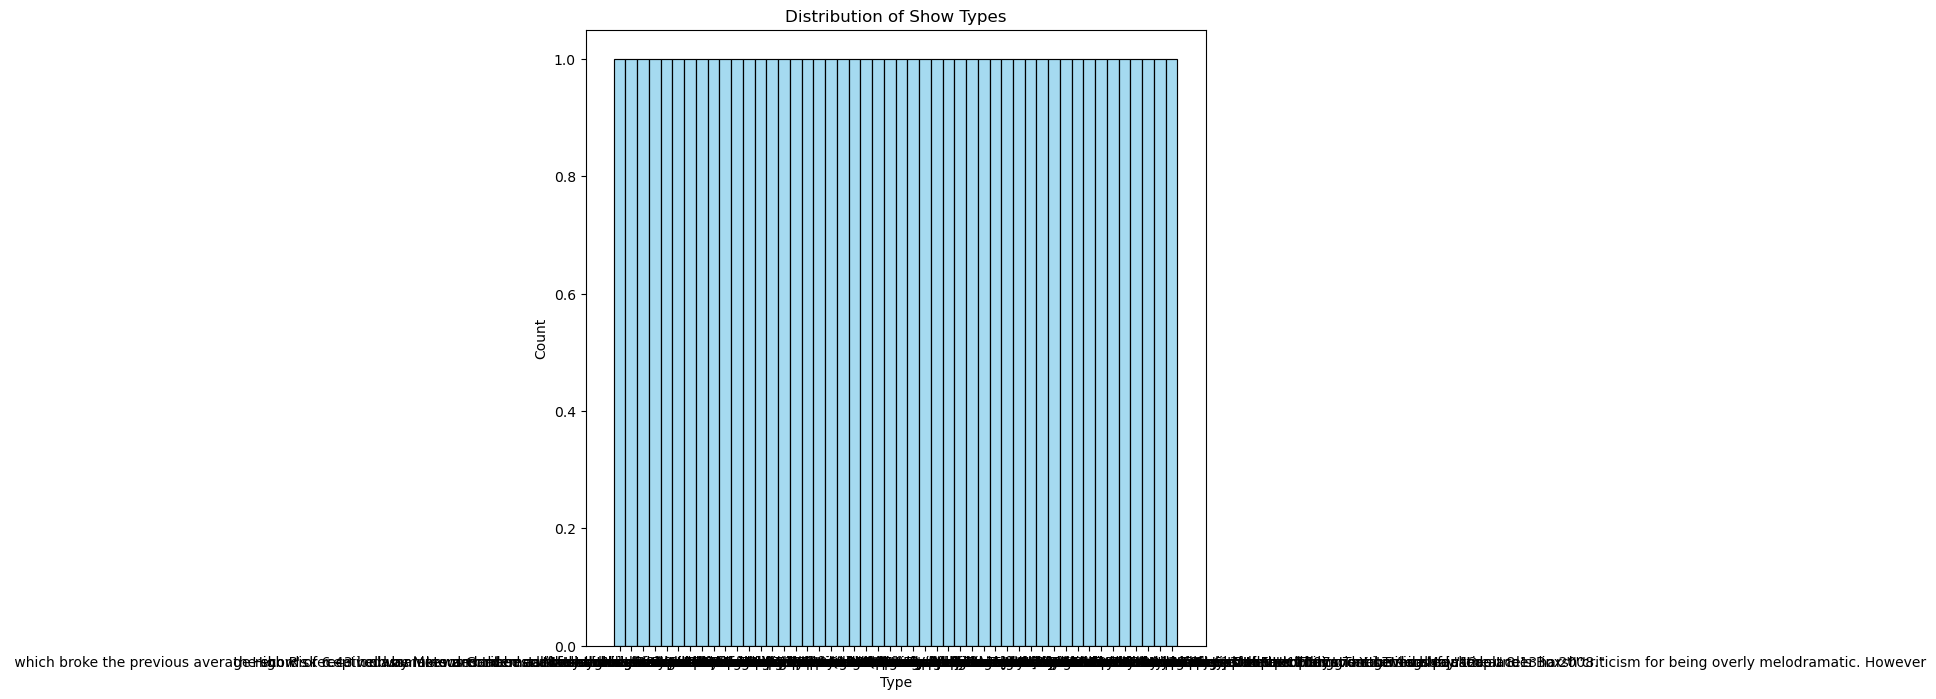

In [40]:
import seaborn as sns

# Convert Spark DataFrame to Pandas
show_type_pd = show_type_df.toPandas()

# Plot distribution using Seaborn
plt.figure(figsize=(8, 8))
sns.histplot(data=show_type_pd, x='type', kde=False, bins=2, color="skyblue")
plt.title("Distribution of Show Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


## Content released over the years

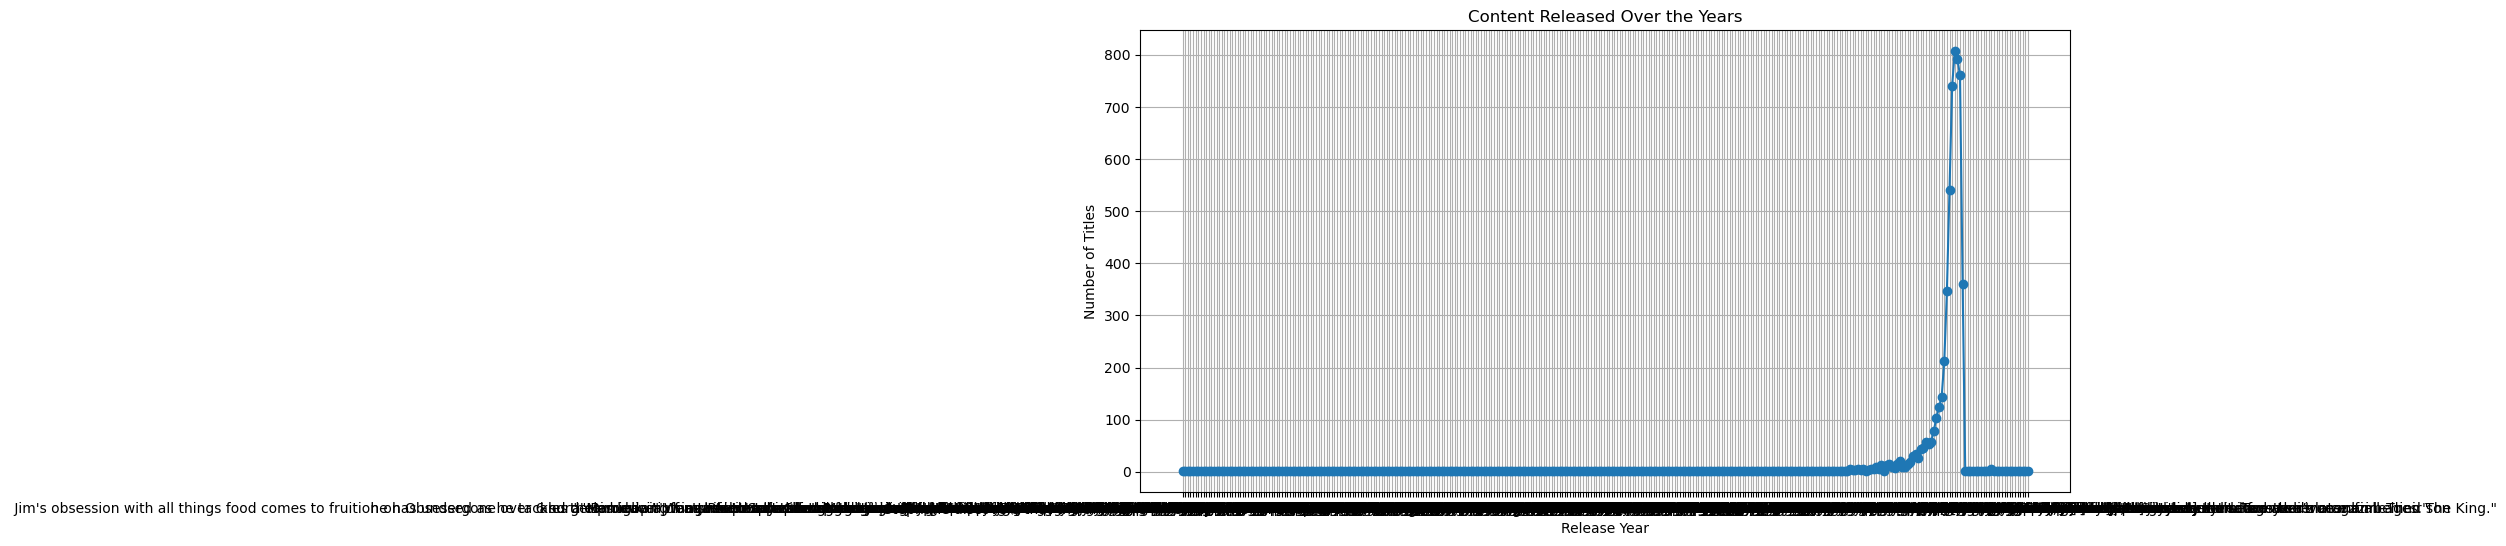

In [41]:
# Step 7: Number of Titles Released Over the Years
year_df = df_cleaned.groupBy("release_year").count().orderBy("release_year")
year_pd = year_df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(year_pd["release_year"], year_pd["count"], marker='o')
plt.title("Content Released Over the Years")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.grid()
plt.show()

## Top 10 Countries producing content

/tmp/ipykernel_331/2885130916.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries_pd, x="count", y="production_countries", palette="coolwarm")


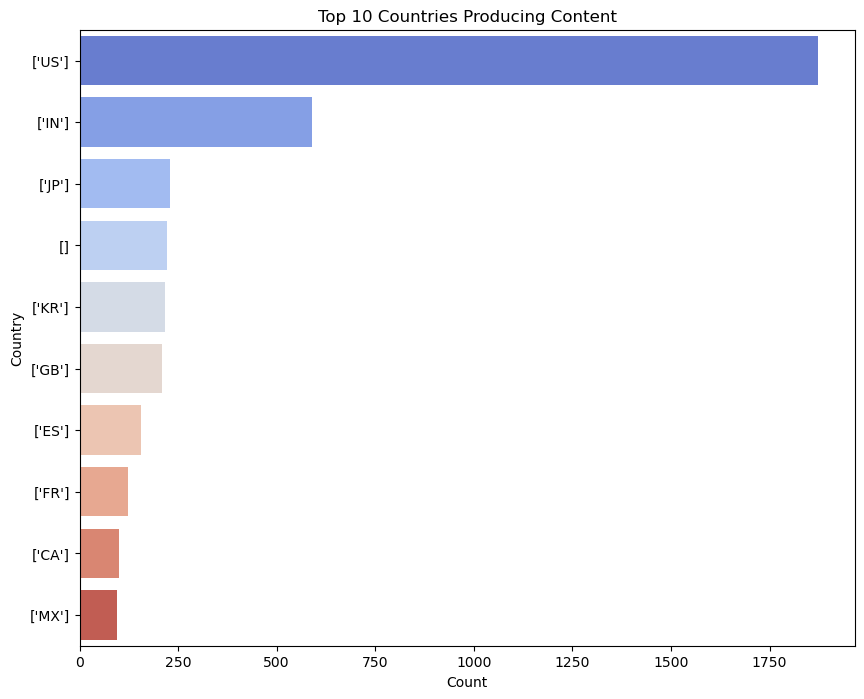

In [46]:

# Step 1: Handle nulls and clean the 'country' column
df_cleaned = df_cleaned.withColumn(
    "country", when(col("production_countries").isNull(), "Unknown").otherwise(col("production_countries"))
)

# Step 2: Group by country, count the content, and order by descending count
top_countries_df = (
    df_cleaned.groupBy("production_countries")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

# Step 3: Convert Spark DataFrame to Pandas
top_countries_pd = top_countries_df.toPandas()

# Step 4: Visualization using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(data=top_countries_pd, x="count", y="production_countries", palette="coolwarm")
plt.title("Top 10 Countries Producing Content")
plt.xlabel("Count")
plt.ylabel("Country")
plt.show()


## Top 10 Popular Genres

/tmp/ipykernel_331/2011817283.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=popular_genres_pd, x="count", y="genres", palette="viridis")


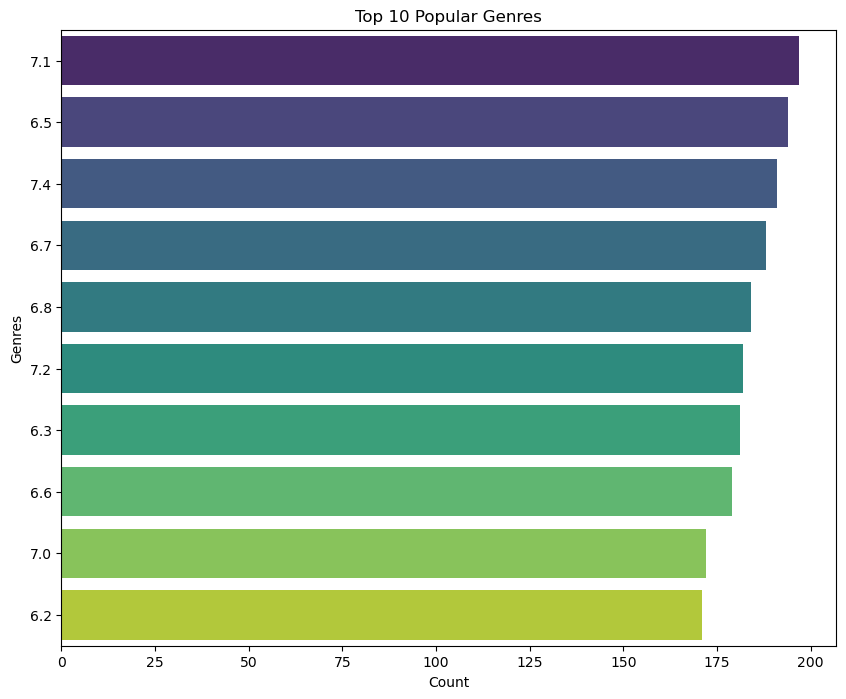

In [52]:
from pyspark.sql.functions import col, split, explode, when, trim

# Step 1: Replace nulls and ensure clean data in 'listed_in'
df_cleaned = df_cleaned.withColumn(
    "imdb_score", when(col("imdb_score").isNull(), "").otherwise(trim(col("imdb_score")))
)

# Step 2: Split and explode the 'listed_in' column to extract individual genres
genres_df = df_cleaned.withColumn(
    "genres", explode(split(col("imdb_score"), ","))
).select(trim(col("genres")).alias("genres"))

# Step 3: Remove empty strings and count occurrences of genres
popular_genres_df = (
    genres_df.filter(col("genres") != "")  # Exclude empty strings
    .groupBy("genres")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

# Step 4: Convert Spark DataFrame to Pandas for visualization
popular_genres_pd = popular_genres_df.toPandas()

# Step 5: Visualization using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(data=popular_genres_pd, x="count", y="genres", palette="viridis")
plt.title("Top 10 Popular Genres")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.show()


## Stopping Spark Session

In [53]:
# Step 11: Stop the SparkSession
spark.stop()